In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
import torch
from torch_geometric.data import HeteroData
from sklearn.preprocessing import LabelEncoder

In [3]:
root_dir = 'data/movie-lens/ml-1m/'
ratings_data_path = os.path.join(root_dir, 'ratings.dat')
movies_data_path = os.path.join(root_dir, 'movies.dat')
users_data_path = os.path.join(root_dir, 'users.dat')

In [36]:
# Read users
users = pd.read_csv(users_data_path, sep="::", engine="python", encoding="ISO-8859-1", names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])
print(users.head())

# Read movies
movies = pd.read_csv(movies_data_path, sep="::", engine="python", encoding="ISO-8859-1", names=["MovieID", "Title", "Genres"])
print(movies.head())

# Read ratings
ratings = pd.read_csv(ratings_data_path, sep="::", engine="python", encoding="ISO-8859-1", names=["UserID", "MovieID", "Rating", "Timestamp"])
print(ratings.head())

   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291


In [107]:
from datetime import datetime
ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit='s')

In [135]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
1000138,6039,847,4,2000-04-25 23:05:32
1000153,6039,2315,4,2000-04-25 23:05:54
999873,6039,589,5,2000-04-25 23:05:54
1000007,6039,1892,4,2000-04-25 23:06:17
1000192,6039,1950,5,2000-04-25 23:06:17


In [136]:
print(f"Start Time = {ratings['Timestamp'].min()}")
print(f"End Time = {ratings['Timestamp'].max()}")

Start Time = 2000-04-25 23:05:32
End Time = 2003-02-28 17:49:50


In [146]:
ratings = ratings.sort_values(by=['Timestamp']).reset_index()
ratings.head()

,index,UserID,MovieID,Rating,Timestamp
0,1000138,6039,847,4,2000-04-25 23:05:32
1,1000153,6039,2315,4,2000-04-25 23:05:54
2,999873,6039,589,5,2000-04-25 23:05:54
3,1000007,6039,1892,4,2000-04-25 23:06:17
4,1000192,6039,1950,5,2000-04-25 23:06:17


In [147]:
import math

In [148]:
train_prop = 0.8
val_prop = 0.1
test_prop = 0.1
num_samples = len(ratings)
train_start_idx = 0
train_end_idx = train_start_idx + math.floor(num_samples*train_prop)
val_start_idx = train_end_idx + 1
val_end_idx = val_start_idx + math.floor(num_samples*val_prop)
test_start_idx = val_end_idx + 1
test_end_idx = test_start_idx + math.floor(num_samples*test_prop) - 1 

In [149]:
len(ratings)

1000209

In [150]:
test_end_idx

1000208

In [151]:
train_start_time = ratings['Timestamp'].iloc[train_start_idx]
train_end_time = ratings['Timestamp'].iloc[train_end_idx]
val_start_time = ratings['Timestamp'].iloc[val_start_idx]
val_end_time = ratings['Timestamp'].iloc[val_end_idx]
test_start_time = ratings['Timestamp'].iloc[test_start_idx]
test_end_time = ratings['Timestamp'].iloc[test_end_idx]

In [152]:
print(f"{train_start_time = }")
print(f"{train_end_time = }")
print(f"{val_start_time = }")
print(f"{val_end_time = }")
print(f"{test_start_time = }")
print(f"{test_end_time = }")

train_start_time = Timestamp('2000-04-25 23:05:32')
train_end_time = Timestamp('2000-12-02 14:52:18')
val_start_time = Timestamp('2000-12-02 14:52:28')
val_end_time = Timestamp('2000-12-29 23:43:34')
test_start_time = Timestamp('2000-12-29 23:43:48')
test_end_time = Timestamp('2003-02-28 17:49:50')


In [37]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

In [38]:
user_encoder.fit(users['UserID'])
movie_encoder.fit(movies['MovieID'])

LabelEncoder()

In [39]:
users['UserID'] = user_encoder.transform(users['UserID'])
movies['MovieID'] = movie_encoder.transform(movies['MovieID'])
ratings['MovieID'] = movie_encoder.transform(ratings['MovieID'])
ratings['UserID'] = user_encoder.transform(ratings['UserID'])

In [40]:
# create the graph 
# Create features
num_users = ratings['UserID'].nunique()
num_movies = ratings['MovieID'].nunique()
user_features = torch.eye(num_users)  # Dummy features for users
movie_features = torch.eye(num_movies)  # Dummy features for movies

In [49]:
print(f"Number of users = {num_users}")
print(f"NUmber of Movies = {num_movies}")

Number of users = 6040
NUmber of Movies = 3706


In [41]:
user_features.shape

torch.Size([6040, 6040])

In [42]:
movie_features.shape

torch.Size([3706, 3706])

In [43]:
# Create edge indices for the bipartite graph
edge_index_user_to_movie = torch.tensor(ratings[['UserID', 'MovieID']].values.T, dtype=torch.long)

In [50]:
edge_index_user_to_movie

tensor([[   0,    0,    0,  ..., 6039, 6039, 6039],
        [1176,  655,  902,  ...,  558, 1080, 1081]])

In [44]:
from torch_geometric.data import HeteroData

data = HeteroData()

# Add nodes
data['user'].x = user_features  # User features
data['movie'].x = movie_features  # Movie features

# Add edges
data['user', 'rates', 'movie'].edge_index = edge_index_user_to_movie
data['movie', 'rated_by', 'user'].edge_index = edge_index_user_to_movie[[1, 0]]  # Reverse edge

In [45]:
data 

HeteroData(
  user={ x=[6040, 6040] },
  movie={ x=[3706, 3706] },
  (user, rates, movie)={ edge_index=[2, 1000209] },
  (movie, rated_by, user)={ edge_index=[2, 1000209] }
)

In [46]:
data['user', 'rates', 'movie']

{'edge_index': tensor([[   0,    0,    0,  ..., 6039, 6039, 6039],
        [1176,  655,  902,  ...,  558, 1080, 1081]])}

In [51]:
edge_index_user_to_movie

tensor([[   0,    0,    0,  ..., 6039, 6039, 6039],
        [1176,  655,  902,  ...,  558, 1080, 1081]])

In [54]:
edge_index_user_to_movie[1].max()

tensor(3882)

In [55]:
ratings[ratings['MovieID'] == 3882]

,UserID,MovieID,Rating,Timestamp
2898,22,3882,4,978461000
5086,35,3882,5,978062904
7310,51,3882,4,977947102
10077,71,3882,5,977868330
13099,101,3882,3,1039274093
...,...,...,...,...
964309,5811,3882,4,992072099
967122,5830,3882,3,986223125
968244,5836,3882,4,1011902656
982282,5926,3882,1,979852537


In [56]:
movies[movies['MovieID'] == 3882]

,MovieID,Title,Genres
3882,3882,"Contender, The (2000)",Drama|Thriller


In [48]:
edge_index_user_to_movie

tensor([[   0,    0,    0,  ..., 6039, 6039, 6039],
        [1176,  655,  902,  ...,  558, 1080, 1081]])

In [60]:
user_encoder.classes_.max()

np.int64(6040)

In [20]:
from torch_geometric.nn import SAGEConv
import torch.nn as nn
import torch.nn.functional as F

class PinSAGEModel(nn.Module):
    def __init__(self, user_dim, movie_dim, hidden_dim, num_layers):
        super(PinSAGEModel, self).__init__()
        # Node embeddings for users and movies
        self.user_embedding = nn.Embedding(user_dim, hidden_dim)
        self.movie_embedding = nn.Embedding(movie_dim, hidden_dim)
        
        # Define SAGEConv layers for heterogeneous graph
        self.user_to_movie_convs = nn.ModuleList([
            SAGEConv((hidden_dim, hidden_dim), hidden_dim) for _ in range(num_layers)
        ])
        self.movie_to_user_convs = nn.ModuleList([
            SAGEConv((hidden_dim, hidden_dim), hidden_dim) for _ in range(num_layers)
        ])

    def forward(self, x_dict, edge_index_dict):
        # Extract node features
        x_dict['user'] = self.user_embedding.weight
        x_dict['movie'] = self.movie_embedding.weight

        # Apply message passing for each layer
        for user_to_movie_conv, movie_to_user_conv in zip(self.user_to_movie_convs, self.movie_to_user_convs):
            # User-to-movie aggregation
            movie_feats = user_to_movie_conv(
                (x_dict['user'], x_dict['movie']),
                edge_index_dict[('user', 'rates', 'movie')]
            )
            
            # Movie-to-user aggregation
            user_feats = movie_to_user_conv(
                (x_dict['movie'], x_dict['user']),
                edge_index_dict[('movie', 'rated_by', 'user')]
            )
            
            # Update features
            x_dict['movie'] = F.relu(movie_feats)
            x_dict['user'] = F.relu(user_feats)

        return x_dict


In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PinSAGEModel(user_encoder.classes_.max(), movie_encoder.classes_.max(), hidden_dim=64, num_layers=2).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [62]:
model

PinSAGEModel(
  (user_embedding): Embedding(6040, 64)
  (movie_embedding): Embedding(3952, 64)
  (user_to_movie_convs): ModuleList(
    (0-1): 2 x SAGEConv((64, 64), 64, aggr=mean)
  )
  (movie_to_user_convs): ModuleList(
    (0-1): 2 x SAGEConv((64, 64), 64, aggr=mean)
  )
)

In [63]:
def compute_loss(user_emb, movie_emb, edge_index):
    # Positive edges
    pos_user = edge_index[0]
    pos_movie = edge_index[1]

    # Negative edges (random sampling)
    neg_movie = torch.randint(0, movie_emb.size(0), (edge_index.size(1),), device=edge_index.device)

    pos_score = (user_emb[pos_user] * movie_emb[pos_movie]).sum(dim=1)
    neg_score = (user_emb[pos_user] * movie_emb[neg_movie]).sum(dim=1)
    # constractive loss ficntion using negative sampling to learn the node embeddings
    loss = -torch.log(torch.sigmoid(pos_score - neg_score)).mean()
    return loss

In [64]:
for edge_type, node_type in data.edge_index_dict.items():
    print(f"{node_type = }")
    print(f"{edge_type = }")

node_type = tensor([[   0,    0,    0,  ..., 6039, 6039, 6039],
        [1176,  655,  902,  ...,  558, 1080, 1081]])
edge_type = ('user', 'rates', 'movie')
node_type = tensor([[1176,  655,  902,  ...,  558, 1080, 1081],
        [   0,    0,    0,  ..., 6039, 6039, 6039]])
edge_type = ('movie', 'rated_by', 'user')


In [65]:
data.x_dict

{'user': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 'movie': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]])}

In [66]:
data.x_dict

{'user': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 'movie': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]])}

In [67]:
for epoch in range(10):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(data.x_dict, data.edge_index_dict)
    user_emb = out['user']
    movie_emb = out['movie']

    # Compute loss
    edge_index = data['user', 'rates', 'movie'].edge_index
    loss = compute_loss(user_emb, movie_emb, edge_index)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.7183098196983337
Epoch 2, Loss: 0.6692832708358765
Epoch 3, Loss: 0.617656946182251
Epoch 4, Loss: 0.5415591597557068
Epoch 5, Loss: 0.47715726494789124
Epoch 6, Loss: 0.4393389821052551
Epoch 7, Loss: 0.42882657051086426
Epoch 8, Loss: 0.4154663681983948
Epoch 9, Loss: 0.39909571409225464
Epoch 10, Loss: 0.39141398668289185


In [68]:
# Extract embeddings
user_embeddings = model.user_embedding.weight
movie_embeddings = model.movie_embedding.weight

# Example: Compute similarity between a user and movies
user_id = 0  # Example user
similarity_scores = torch.matmul(user_embeddings[user_id], movie_embeddings.T)

# Recommend top 5 movies
recommended_movies = similarity_scores.argsort(descending=True)[:5]
print("Recommended Movies:", recommended_movies)

Recommended Movies: tensor([1275, 1256,  645, 3922,  347])


In [70]:
user_embeddings.shape

torch.Size([6040, 64])

In [71]:
movie_embeddings.shape

torch.Size([3952, 64])

In [72]:
from sklearn.manifold import TSNE

In [73]:
with torch.no_grad():
    # Forward pass to get embeddings
    output = model(data.x_dict, data.edge_index_dict)
    movie_embeddings = output['movie']  # Shape: (num_movies, hidden_dim)

In [74]:
# Convert to CPU for t-SNE
movie_embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(movie_embeddings.cpu().numpy())

In [86]:
def get_first_genre(x):
    if '|' in str(x):
        return x.split('|')[0]
    return ""

In [101]:
# Load movie metadata for labeling
# movies['MappedID'] = movies['MovieID'].map(movie_encoder)  # Map MovieID to embedding indices

# Merge movie embeddings with genres
movie_data = pd.DataFrame(movie_embeddings_2d, columns=['x', 'y'])
movie_data['MovieID'] = range(0, len(movie_data))
movie_data = movie_data.join(movies, how = 'left', on='MovieID', rsuffix="r")
movie_data['Genres'] = movie_data['Genres'].apply(get_first_genre)
genre_encoder = LabelEncoder()
movie_data['Genre_Encoded'] = genre_encoder.fit_transform(movie_data['Genres'])

In [102]:
movie_data

,x,y,MovieID,MovieIDr,Title,Genres,Genre_Encoded
0,41.399239,-28.887938,0,0.0,Toy Story (1995),Animation,3
1,22.415672,-13.283993,1,1.0,Jumanji (1995),Adventure,2
2,-26.682764,-19.669079,2,2.0,Grumpier Old Men (1995),Comedy,5
3,3.219847,10.905919,3,3.0,Waiting to Exhale (1995),Comedy,5
4,39.401268,3.130195,4,4.0,Father of the Bride Part II (1995),,0
...,...,...,...,...,...,...,...
3947,-72.404045,-0.361319,3947,NaN,NaN,,0
3948,-69.966286,-3.976085,3948,NaN,NaN,,0
3949,-77.726357,0.488300,3949,NaN,NaN,,0
3950,-68.737991,-6.105882,3950,NaN,NaN,,0


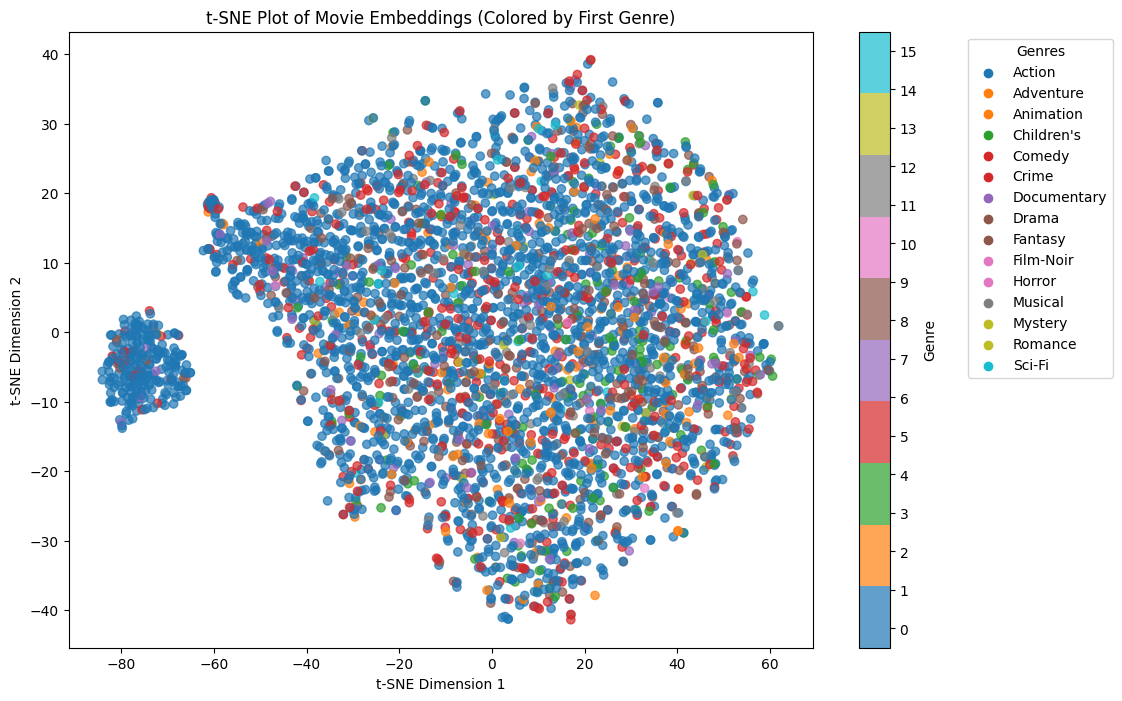

In [104]:
# Step 6: Plot t-SNE with Coloring Based on First Genre
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    movie_data['x'], movie_data['y'], c=movie_data['Genre_Encoded'], cmap='tab10', alpha=0.7
)
plt.colorbar(scatter, ticks=range(len(genre_encoder.classes_)), label='Genre')
plt.clim(-0.5, len(genre_encoder.classes_) - 0.5)
plt.title('t-SNE Plot of Movie Embeddings (Colored by First Genre)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Add legend for genre labels
legend_labels = genre_encoder.classes_
for i, label in enumerate(legend_labels):
    plt.scatter([], [], color=scatter.cmap(i / len(legend_labels)), label=label)
plt.legend(title='Genres', loc='upper left', bbox_to_anchor=(1.2, 1))

plt.show()